# Brain Tumor MRI Classification

## Preparation

### Libraries & Set Up

In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### The Dataset

Total images: 3000

Tumor images: 1500

No tumor images: 1500

In [ ]:
#Path to image folers
no_tumor_folder = '/content/drive/MyDrive/CS 767 Project/data/no'
tumor_folder = '/content/drive/MyDrive/CS 767 Project/data/yes'

### Data Preprocessing

In [ ]:
target_size = (128,128)
images = [] #Store image pixels in array
labels = [] #Tumor or no tumor labels
for filename in os.listdir(no_tumor_folder):
    img = cv2.imread(os.path.join(no_tumor_folder, filename), cv2.IMREAD_GRAYSCALE) #Scans are grayscale images
    if img is not None:
        img = cv2.resize(img, target_size) #Resize to 128x128 square image
        images.append(img)
        labels.append(0) #Label 0 for images with no tumor
for filename in os.listdir(tumor_folder):
    img = cv2.imread(os.path.join(tumor_folder, filename), cv2.IMREAD_GRAYSCALE) #Scans are grayscale images
    if img is not None:
        img = cv2.resize(img, target_size) #Resize to 128x128 square image
        images.append(img)
        labels.append(1) #Label 1 for images with tumor

In [ ]:
X = np.array(images).reshape(3000, 128, 128, 1) #Dimensions are for grayscale images with 128x128 pixels
y = np.array(labels).reshape(3000, 1)

In [ ]:
#Train + Validation: 80%
#Validation: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(f"Train + Validation: {len(y_train)} images\nTest: {len(y_test)} images")

Train + Validation: 2400 images
Test: 600 images


In [ ]:
print(f"X_train shape: {X_train.shape} \ny_train shape: {y_train.shape}")
print(f"\nX_test shape: {X_test.shape} \ny_test shape: {y_test.shape}")

X_train shape: (2400, 128, 128, 1) 
y_train shape: (2400, 1)

X_test shape: (600, 128, 128, 1) 
y_test shape: (600, 1)


In [ ]:
num_classes = 2 #Either No Tumor or Tumor
input_shape = (128, 128, 1) #128x128 pixels

##Vision Transformer

###Hyperparameter Selection

In [ ]:
tf.random.set_seed(42)
initial_learning_rate = 0.001
batch_size = 50
num_epochs = 50
image_size = 64 #Resize shape for data augmentation
patch_size = 6 #Size of patches for separating input image into patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 #Projection dimensions for transformer units
num_heads = 4 #Number of heads for attention
transformer_units = [projection_dim * 2, projection_dim] #Size of transformer layers
transformer_layers = 4 #Number of transformer layers
mlp_head_units = [2048, 1024]  #Size of the dense layers of the final classifier

###Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
     ],
    name="data_augmentation",
)

###Feed Forward

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x) #Prevent overfitting
    return x

###Input Patching

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 36


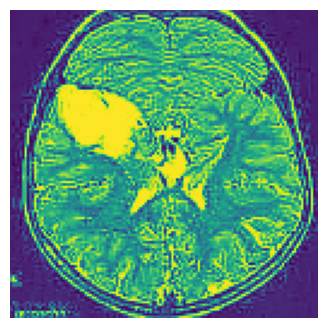

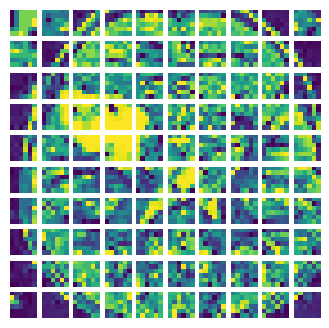

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#Patch encoding to extract lower-level features from the image
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

###Creating ViT Model

In [ ]:
def ViT_model():
    inputs = layers.Input(shape=input_shape) #Defining input layer
    augmented = data_augmentation(inputs) #Data augmentation to prevent overfitting
    patches = Patches(patch_size)(augmented) #Splitting images into patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) #Encoding patches

    #Transformer block
    #Breakdown of each layer:
    #1. Normalization layer 1
    #2. Multi-head attention layer
    #3. Skip connection layer 1
    #4. Normalization layer 2
    #5. Feed Forward
    #6. Skip connection layer 2

    for _ in range(transformer_layers):
        #Normalization layer 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        #Multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        
        #Skip connection layer 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        #Normalization layer 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        #Feed Forward
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        #Skip connection layer 2
        encoded_patches = layers.Add()([x3, x2])

    #Output representation
    #1. Normalization layer
    #2. Flattening layer
    #3. Dropout layer
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    #Output features using feed forward
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    #Probabilities for output classification
    logits = layers.Dense(num_classes)(features)
    
    #Define model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

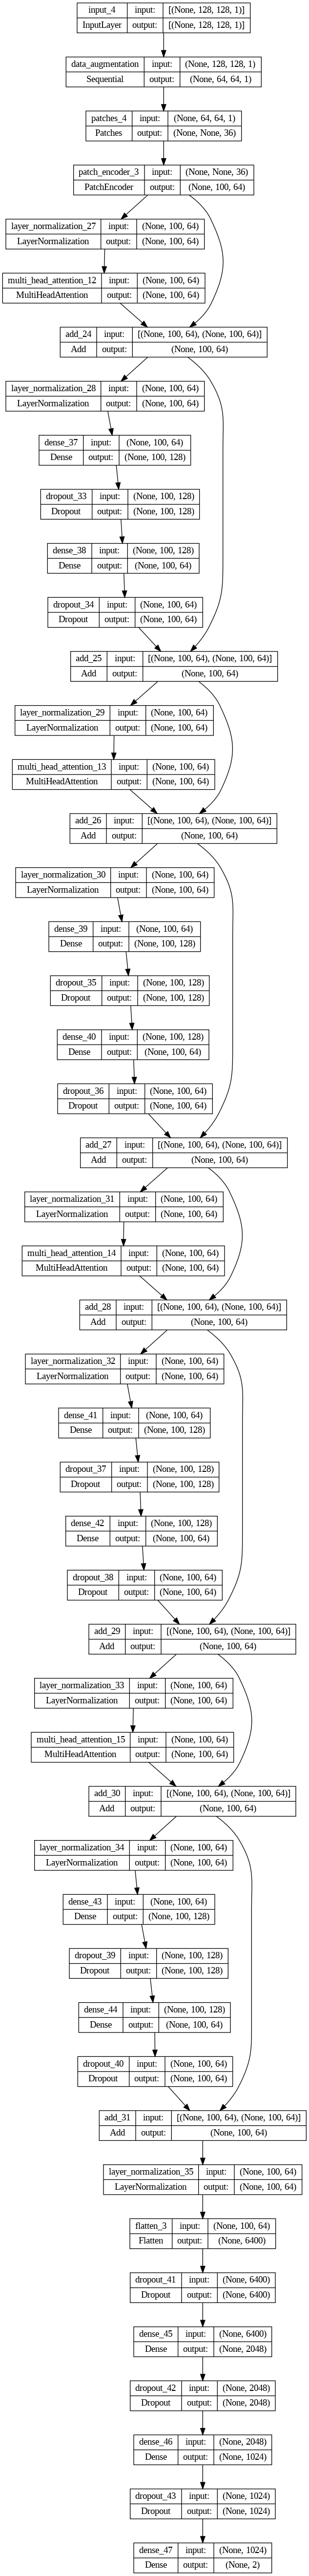

In [ ]:
model = ViT_model()
keras.utils.plot_model(model, "ViT_model.png", show_shapes=True)

##Model Training

In [ ]:
def train_evaluate_model(model, optimizer):
    #Compile model
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    #Save weights
    checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoints", save_weights_only=True)
    
    #Early stopping
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    #Fitting model
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.25,
        callbacks=[checkpoint, callback])

    #Using final weights to label test set and evaluate model
    model.load_weights("my_checkpoints")
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\n\nTest accuracy: {round(accuracy * 100, 2)}%")
    print(f"\nTest loss: {round(loss, 2)}")

    return history

##Hyperparameter Tuning

###Learning Rate Scheduler

####Step Decay

In [ ]:
#Step Decay for training callbacks
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_callback = LearningRateScheduler(lr_scheduler)

####Exponential Decay

In [ ]:
#Exponential Decay for optimizers
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.1

lr_exp = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

####Cosine Decay

In [ ]:
#Cosine Decay for optimizers
initial_learning_rate = 0.001
decay_steps = 1000

lr_cosine = keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps)

###Optimizers

####Adam Optimizer with Exponential Decay

In [ ]:
adam_exp = keras.optimizers.Adam(learning_rate=lr_exp)

####Adam Optimizer with Cosine Decay

In [ ]:
adam_cosine = keras.optimizers.Adam(learning_rate=lr_cosine)

####SGD Optimizer with Exponential Decay

In [ ]:
nesterov_exp = keras.optimizers.SGD(learning_rate=lr_exp)

####SGD Optimizer with Cosine Decay

In [ ]:
nesterov_cosine = keras.optimizers.SGD(learning_rate=lr_cosine)

####RMSProp Optimizer with Exponential Decay

In [ ]:
rmsprop_exp = keras.optimizers.experimental.RMSprop(learning_rate=lr_exp)

####RMSProp Optimizer with Cosine Decay

In [ ]:
rmsprop_cosine = keras.optimizers.experimental.RMSprop(learning_rate=lr_cosine)

##Performance

####Adam Optimizer with Exponential Decay

In [ ]:
history_adam_exp = train_evaluate_model(model, adam_exp)

Epoch 1/50
36/36 [==============================] - 63s 1s/step - loss: 2.8916 - accuracy: 0.5694 - val_loss: 0.5808 - val_accuracy: 0.7300
Epoch 2/50
36/36 [==============================] - 50s 1s/step - loss: 0.8837 - accuracy: 0.6089 - val_loss: 0.7085 - val_accuracy: 0.5367
Epoch 3/50
36/36 [==============================] - 51s 1s/step - loss: 0.6886 - accuracy: 0.6428 - val_loss: 0.5628 - val_accuracy: 0.7433
Epoch 4/50
36/36 [==============================] - 51s 1s/step - loss: 0.6398 - accuracy: 0.6611 - val_loss: 0.6223 - val_accuracy: 0.5867
Epoch 5/50
36/36 [==============================] - 56s 2s/step - loss: 0.6196 - accuracy: 0.6733 - val_loss: 0.5849 - val_accuracy: 0.7050
Epoch 6/50
36/36 [==============================] - 51s 1s/step - loss: 0.5825 - accuracy: 0.6961 - val_loss: 0.5534 - val_accuracy: 0.7483
Epoch 7/50
36/36 [==============================] - 57s 2s/step - loss: 0.5874 - accuracy: 0.7022 - val_loss: 0.5240 - val_accuracy: 0.7583
Epoch 8/50
36/36 [==

####Adam Optimizer with Cosine Decay

In [ ]:
model = ViT_model()
history_adam_cosine = train_evaluate_model(model, adam_cosine)

Epoch 1/50
36/36 [==============================] - 71s 2s/step - loss: 3.3726 - accuracy: 0.5556 - val_loss: 0.5832 - val_accuracy: 0.7383
Epoch 2/50
36/36 [==============================] - 51s 1s/step - loss: 0.7048 - accuracy: 0.6139 - val_loss: 0.5840 - val_accuracy: 0.7000
Epoch 3/50
36/36 [==============================] - 53s 1s/step - loss: 0.6632 - accuracy: 0.6494 - val_loss: 0.5870 - val_accuracy: 0.7683
Epoch 4/50
36/36 [==============================] - 57s 2s/step - loss: 0.6203 - accuracy: 0.6756 - val_loss: 0.5797 - val_accuracy: 0.7050
Epoch 5/50
36/36 [==============================] - 52s 1s/step - loss: 0.6183 - accuracy: 0.6767 - val_loss: 0.5600 - val_accuracy: 0.7183
Epoch 6/50
36/36 [==============================] - 56s 2s/step - loss: 0.6007 - accuracy: 0.7017 - val_loss: 0.5738 - val_accuracy: 0.6650
Epoch 7/50
36/36 [==============================] - 54s 1s/step - loss: 0.6093 - accuracy: 0.6794 - val_loss: 0.5504 - val_accuracy: 0.7300
Epoch 8/50
36/36 [==

####SGD Optimizer with Exponential Decay

In [ ]:
model = ViT_model()
history_nesterov_exp = train_evaluate_model(model, nesterov_exp)

Epoch 1/50
36/36 [==============================] - 53s 1s/step - loss: 1.4777 - accuracy: 0.5272 - val_loss: 0.6981 - val_accuracy: 0.5483
Epoch 2/50
36/36 [==============================] - 45s 1s/step - loss: 1.2721 - accuracy: 0.5267 - val_loss: 0.7465 - val_accuracy: 0.5150
Epoch 3/50
36/36 [==============================] - 47s 1s/step - loss: 1.2384 - accuracy: 0.5294 - val_loss: 0.6026 - val_accuracy: 0.6983
Epoch 4/50
36/36 [==============================] - 47s 1s/step - loss: 1.1112 - accuracy: 0.5583 - val_loss: 0.6156 - val_accuracy: 0.6233
Epoch 5/50
36/36 [==============================] - 47s 1s/step - loss: 1.0530 - accuracy: 0.5594 - val_loss: 0.6108 - val_accuracy: 0.6350
Epoch 6/50
36/36 [==============================] - 46s 1s/step - loss: 1.0284 - accuracy: 0.5606 - val_loss: 0.6100 - val_accuracy: 0.6333
Epoch 7/50
36/36 [==============================] - 50s 1s/step - loss: 1.0273 - accuracy: 0.5417 - val_loss: 0.6031 - val_accuracy: 0.6617
Epoch 8/50
36/36 [==

####SGD Optimizer with Cosine Decay

In [ ]:
model = ViT_model()
history_nesterov_cosine = train_evaluate_model(model, nesterov_cosine)

Epoch 1/50
36/36 [==============================] - 84s 1s/step - loss: 1.4193 - accuracy: 0.5189 - val_loss: 0.7961 - val_accuracy: 0.5817
Epoch 2/50
36/36 [==============================] - 46s 1s/step - loss: 1.2457 - accuracy: 0.5589 - val_loss: 0.7449 - val_accuracy: 0.5933
Epoch 3/50
36/36 [==============================] - 45s 1s/step - loss: 1.2170 - accuracy: 0.5422 - val_loss: 0.7709 - val_accuracy: 0.6000
Epoch 4/50
36/36 [==============================] - 47s 1s/step - loss: 1.0404 - accuracy: 0.5761 - val_loss: 0.6859 - val_accuracy: 0.6233
Epoch 5/50
36/36 [==============================] - 45s 1s/step - loss: 1.0933 - accuracy: 0.5444 - val_loss: 0.6271 - val_accuracy: 0.6617
Epoch 6/50
36/36 [==============================] - 45s 1s/step - loss: 0.9710 - accuracy: 0.5867 - val_loss: 0.6214 - val_accuracy: 0.6633
Epoch 7/50
36/36 [==============================] - 50s 1s/step - loss: 0.9222 - accuracy: 0.6000 - val_loss: 0.6404 - val_accuracy: 0.6500
Epoch 8/50
36/36 [==

####RMSProp Optimizer with Exponential Decay

In [ ]:
model = ViT_model()
history_rmsprop_exp = train_evaluate_model(model, rmsprop_exp)

Epoch 1/50
36/36 [==============================] - 58s 1s/step - loss: 14.5466 - accuracy: 0.5322 - val_loss: 0.8032 - val_accuracy: 0.5400
Epoch 2/50
36/36 [==============================] - 50s 1s/step - loss: 0.9362 - accuracy: 0.5844 - val_loss: 0.6010 - val_accuracy: 0.7033
Epoch 3/50
36/36 [==============================] - 49s 1s/step - loss: 0.7961 - accuracy: 0.5961 - val_loss: 0.7094 - val_accuracy: 0.5500
Epoch 4/50
36/36 [==============================] - 50s 1s/step - loss: 0.7102 - accuracy: 0.6317 - val_loss: 0.6202 - val_accuracy: 0.7267
Epoch 5/50
36/36 [==============================] - 50s 1s/step - loss: 0.6514 - accuracy: 0.6722 - val_loss: 0.5767 - val_accuracy: 0.7750
Epoch 6/50
36/36 [==============================] - 50s 1s/step - loss: 0.6314 - accuracy: 0.6733 - val_loss: 0.5921 - val_accuracy: 0.7667
Epoch 7/50
36/36 [==============================] - 56s 2s/step - loss: 0.5760 - accuracy: 0.7244 - val_loss: 0.5793 - val_accuracy: 0.7517
Epoch 8/50
36/36 [=

####RMSProp Optimizer with Cosine Decay

In [ ]:
model = ViT_model()
history_rmsprop_cosine = train_evaluate_model(model, rmsprop_cosine)

Epoch 1/50
36/36 [==============================] - 59s 1s/step - loss: 13.4115 - accuracy: 0.5500 - val_loss: 1.4715 - val_accuracy: 0.4917
Epoch 2/50
36/36 [==============================] - 50s 1s/step - loss: 1.0115 - accuracy: 0.5617 - val_loss: 0.6665 - val_accuracy: 0.4883
Epoch 3/50
36/36 [==============================] - 50s 1s/step - loss: 0.7791 - accuracy: 0.6083 - val_loss: 0.5988 - val_accuracy: 0.7450
Epoch 4/50
36/36 [==============================] - 49s 1s/step - loss: 0.7676 - accuracy: 0.6228 - val_loss: 0.6276 - val_accuracy: 0.6250
Epoch 5/50
36/36 [==============================] - 50s 1s/step - loss: 0.6525 - accuracy: 0.6428 - val_loss: 0.6074 - val_accuracy: 0.7467
Epoch 6/50
36/36 [==============================] - 48s 1s/step - loss: 0.6244 - accuracy: 0.6922 - val_loss: 0.5752 - val_accuracy: 0.7633
Epoch 7/50
36/36 [==============================] - 50s 1s/step - loss: 0.6156 - accuracy: 0.6933 - val_loss: 0.5919 - val_accuracy: 0.7783
Epoch 8/50
36/36 [=

##Best Model

The best model is with Exponential Decay learning rate scheduler and RMSProp optimizer.

Test accuracy of best model: 88.83%

Test loss of best model: 0.33

##References

https://keras.io/examples/vision/image_classification_with_vision_transformer/